![Practicum AI Logo image](https://github.com/PracticumAI/practicumai.github.io/blob/main/images/logo/PracticumAI_logo_250x50.png?raw=true) <img src="https://github.com/PracticumAI/practicumai.github.io/blob/84b04be083ca02e5c7e92850f9afd391fc48ae2a/images/icons/practicumai_computer_vision.png?raw=true" alt="Practicum AI: Computer Vision icon" align="right" width=50>
***

# Computer Vision Concepts

You may recall *Practicum AI*"s heroine Amelia, the AI-savvy nutritionist. At the end of our *[Deep Learning Foundations course](https://practicumai.org/courses/deep_learning/)*, Amelia was helping with a computer vision project. Her colleague, an entomologist named Kevin, had a dataset of images of bees and wasps and wanted to classify them.

![Image of bees and wasps from the dataset cover image](https://github.com/PracticumAI/deep_learning/blob/main/images/bees_wasps_dataset-cover.png?raw=true)


## AI Pathway review for Bees vs Wasps

If you have taken our *[Getting Started with AI course]*(https://practicumai.org/courses/getting_started/), you may remember this figure of the **AI Application Development Pathway**. Let's take a quick review of how we applied this pathway in the case of the Bees vs Wasps example.

![AI Application Development Pathway image showing the 7 steps in developing an AI application](https://practicumai.org/getting_started/images/application_dev_pathway.png)

1. **Choose a problem to solve:** In this example, we need to classify images as bees, wasps, other insects, or a non-insect. 
2. **Gather data:** The data for the example come from [Kaggle](https://www.kaggle.com/datasets/jerzydziewierz/bee-vs-wasp), a great repository of datasets, code, and models.
3. **Clean and prepare the data:** In the *Deep Learning Foundations* course, we assumed that this was done for us. One issue that we ran into was that of class imbalance. There are many more images in some classes than others, leading to a poor performing model. We won't address this yet, but will come back to it in notebook [01.2_data_imbalance.ipynb](01.2_data_imbalance.ipynb).
4. **Choose a model:** In the *Deep Learning Foundations* course, we presented the model with little detail. Now that we know more about Convolutional Neural Networks (CNNs) and some other tools at our disposal, we will explore the model in more detail.
   * As part of the iterative process of training models, one thing we noticed is that most of our models were **overfitting** — performing better on the training data than they did on the testing data. Essentially, the models memorized the training data but did not generalize well to new data that had not been seen. 
      * In this notebook, we will explore **dropout** as one mechanism to mitigate overfitting.
5. **Train the model:** In training the model we may have had a few issues. With so many hyperparameters to tune, it's easy to lose track of what combinations have been tried and how changes impacted model performance. 
   * In this notebook, we introduce you to [TensorBoard](https://www.tensorflow.org/tensorboard), one popular tool in a class of tools known as **experiment tracking** or **MLOps (Machine learning operations) tools**. These tools help track changes to hyperparameters, the training process, and the data. They allow comparison among runs and can even automate multiple runs for you. Learning to use MLOps tools will help you as you continue to learn more about AI workflows.
6. **Evaluate the model:** We will continue to assess how the model performs on the validation set and adjust the model and hyperparameters to attempt to produce a better model. However, as noted above in step 3, one issue we will continue to encounter is the class imbalance.    
   * This is a common issue with real data, and in notebook [01.2_data_imbalance.ipynb](01.2_data_imbalance.ipynb), we will explore some methods to handle this.
7. **Deploy the model:** We won"t get to this stage in this exercise, but hopefully, we will end up with a model that could be deployed and achieve relatively good accuracy at solving the problem.


## A refresher

If you need a refresher, or haven"t taken the *Deep Learning Foundations* course, the final notebook is part of this repository: [DLF_03_bees_vs_wasps.ipynb](DLF_03_bees_vs_wasps.ipynb). No need to worry though, we will cover what we did before and the new changes as we work through this notebook. Some of the code has been updated to work better with the new things we add in this exercise and moved into the [helpers_01.py](helpers_01.py) file. It is imported below ratehr than included in the notebook to keep things cleaner.

## Outline of this notebook

This notebook covers a fair bit of ground. To orient you, here's an outline of the topics covered. Note that you can also open the notebook outline to see section headers.

1. Run through loading the data and exploring it a bit ([sections 1](#1.-Import-the-libraries-we-will-use) through 5).
1. Set initial hyperparameters, train a CNN model, and evaluate the performance ([sections 6](#6.-Make-our-model) through 8).
1. Explore Tensorboard as a tool to gain more insight into model performance ([section 9](#9.-View-training-metrics-in-TensorBoard)).
1. Spend some time tuning hyperparameters and evaluating the impact on model performance ([section 10](#10.-Explore-hyperparameters!))
1. Summarize the results obtaiend so far ([section 11](#11.-Summary-so-far))
1. Explore what a convolutional kernel is in more detail, visualizing kernels and convolved images ([section 12](#12.-A-look-inside-CNNs))
1. Add dropout to our model ([section 13](#13.-Dropout)) and discuss the padding and stride hyperparameters ([section 14](#14.-Padding-and-stride-for-convolutional-layers))
1. Conclude with a summary of the results and motivate the next notebook ([section 15](#15.-Conclusion))

## 1. Import the libraries we will use

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl
from pytorch_lightning import Trainer

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image
import numpy as np
from pathlib import Path

# This has a lot of helper functions moved out of the main notebook to keep things clean
import helpers_01

## 2. Check PyTorch installation

In [2]:
# Print Pytorch versions and check for GPU
print(f'Pytorch version: {torch.__version__}')
print(f'  Should be "True" if Pytorch was built for GPU: {torch.cuda.is_available()}')
if torch.cuda.is_available():
    print(f'  Available GPU: {torch.cuda.get_device_name()}')
else:
    print('  No GPU available, will use CPU')

Pytorch version: 2.7.1+cu128
  Should be "True" if Pytorch was built for GPU: True
  Available GPU: NVIDIA B200


## 3. Getting the data

Check the "Getting the data" section of [DLF_03_bees_vs_wasps.ipynb](DLF_03_bees_vs_wasps.ipynb#2.-Getting-the-data) for details about the dataset and the code used to get the data if needed. Or you can look at the [helpers_01.py file](helpers_01.py). 

If you need to download the data, it is [hosted for public download from HiPerGator as a `tar.gz` file](https://data.rc.ufl.edu/pub/practicum-ai/Deep_Learning_Foundations/bee_vs_wasp.tar.gz). If you need to manually extract the data, you can add a cell and run: `helpers_01.extract_file("bee_vs_wasp.tar.gz", "data")`


In [13]:
# Check for the data.
# This will look for the data files required for this notebook in some common locations.
# If it can"t find the data, it will ask if you know where it is. If you do, answer yes and
# provide the path to the data (up to and including the `bee_vs_wasp` folder name). If not,
# it will ask if you want to download it. If you answer yes, it will download the data and
# extract it into your data folder.

data_path = helpers_01.manage_data(folder_name='bee_vs_wasp_reduced',)

Found data at data/bee_vs_wasp_reduced.


## 4. Examine some images

Many of the steps in this notebook are written as functions, making it easier to run these steps repeatedly as you work on optimizing the various hyperparameters.

The `helpers_01.load_display_data()` function takes: 
* A path to the data: set from above.
* The batch size: set as 32 below, but a good hyperparameter to tune.
* Target shape for images: set as 80x80 color images below, another possible hyperparameter.
* Whether or not to show sample images.

The function returns training and validation datasets. To help highlight the class imbalance issue, the function has been updated to report the numbers of images and percent of the total in each class.

## 4. Examine some images

Many of the steps in this notebook are written as functions, making it easier to run these steps repeatedly as you work on optimizing the various hyperparameters.

The `helpers_01.load_display_data()` function takes: 
* A path to the data: set from above.
* The batch size: set as 32 below, but a good hyperparameter to tune.
* Target shape for images: set as 80x80 color images below, another possible hyperparameter.
* Whether or not to show sample images.

The function returns training and validation datasets. To help highlight the class imbalance issue, the function has been updated to report the numbers of images and percent of the total in each class.

## 5. Optional: Custom Dataset Class

This cell shows an alternative way to create a custom dataset class if needed for experimentation. Since we're using the helpers_01 functions, this is just for reference.

******************************************************************
Load data:
  - Loading the dataset from: data/bee_vs_wasp_reduced.
  - Using a batch size of: 32.
  - Resizing input images to: (80, 80, 3).
  - Stratify when sampling? False
  - Returning class counts for later use? False
******************************************************************

For the full dataset: 
   Class          # of images     # of total
--------------------------------------------
 other_noinsect         252         25.0%
            bee         249         24.7%
           wasp         252         25.0%
   other_insect         254         25.2%
--------------------------------------------
The classes in your dataset are: ['bee', 'other_insect', 'other_noinsect', 'wasp']


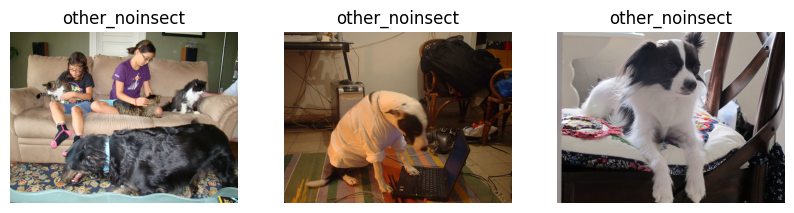

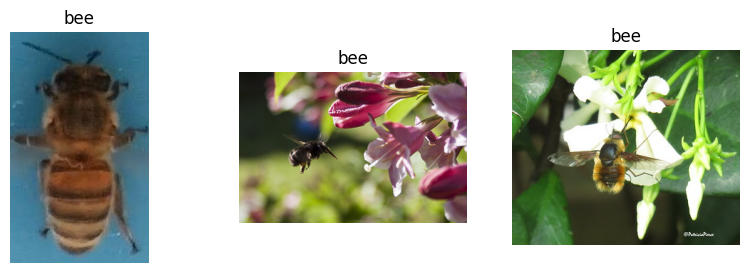

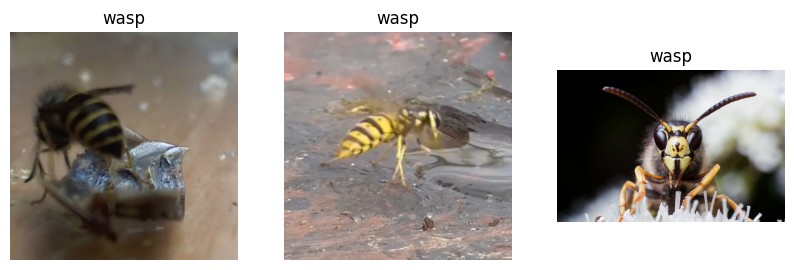

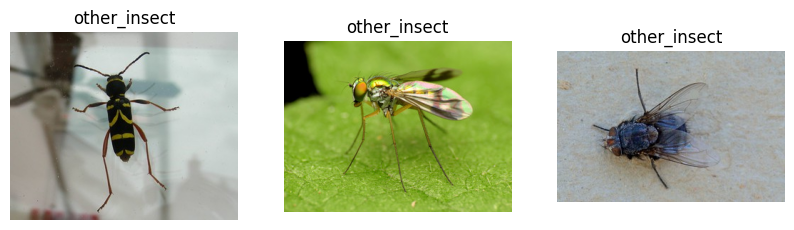

In [ ]:
# Use the function from helpers_01 directly
data_train, data_valid = helpers_01.load_display_data(
    data_path, batch_size=32, shape=(80,80,3), show_pictures=True
)

## 6. Train the Model

In [ ]:
# This is optional - just showing how to create a custom dataset
# We're using the data loaders from helpers_01.load_display_data() above

class BeeWaspDataset(Dataset):
    def __init__(self, data_path, transform=None):
        self.data_path = Path(data_path)
        self.transform = transform
        self.images = []
        self.labels = []
        
        # Get class names and build file lists
        self.class_names = [item.name for item in self.data_path.iterdir() if item.is_dir()]
        for idx, class_name in enumerate(self.class_names):
            class_path = self.data_path / class_name
            class_files = [img for img in class_path.iterdir() if img.is_file()]
            self.images.extend([str(img) for img in class_files])
            self.labels.extend([idx] * len(class_files))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

print("Custom dataset class defined (but not used in this workflow)")

Custom dataset class defined (but not used in this workflow)


## 7. Evaluate the Model

In [17]:
# Create and train the model using PyTorch Lightning
model = helpers_01.make_model(num_classes=4, learning_rate=0.001)

# Train the model using Lightning trainer
trained_model, trainer = helpers_01.compile_train_model(
    data_train, 
    data_valid, 
    model=model, 
    num_epochs=10,
    learning_rate=0.001,
    num_classes=4
)

Using device: cuda
Epoch 1/10, Loss: 1.3209816400821393
Validation Loss: 1.1503585577011108
Epoch 2/10, Loss: 1.1642651512072637
Validation Loss: 1.0499045167650496
Epoch 3/10, Loss: 1.062569288107065
Validation Loss: 1.0367249931607927
Epoch 4/10, Loss: 0.9598540938817538
Validation Loss: 0.9583963836942401
Epoch 5/10, Loss: 0.962679766691648
Validation Loss: 0.9166561620576041
Epoch 6/10, Loss: 0.8420436542767745
Validation Loss: 0.9096293704850333
Epoch 7/10, Loss: 0.8021528927179483
Validation Loss: 0.8566867198262896
Epoch 8/10, Loss: 0.764746388563743
Validation Loss: 0.8454345038958958
Epoch 9/10, Loss: 0.7172780587122991
Validation Loss: 0.8391610639435905
Epoch 10/10, Loss: 0.6722971430191627
Validation Loss: 0.8084083454949516


In [18]:
# Evaluate the model using Lightning
results = helpers_01.evaluate_model(data_valid, trained_model, trainer)

# You can also view TensorBoard logs by running:
# %load_ext tensorboard
# %tensorboard --logdir lightning_logs/

Accuracy: 65.84158415841584%
